In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import wiener
from skimage import io, color, data

In [13]:
img = cv2.imread('03_image.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


In [24]:
eq = cv2.equalizeHist(img_gray)
cv2.imwrite('histogram_equalization.jpg', eq)

True

In [75]:
denoised = cv2.medianBlur(eq, 3)
cv2.imwrite('wiener_denoised.jpg', denoised)

True

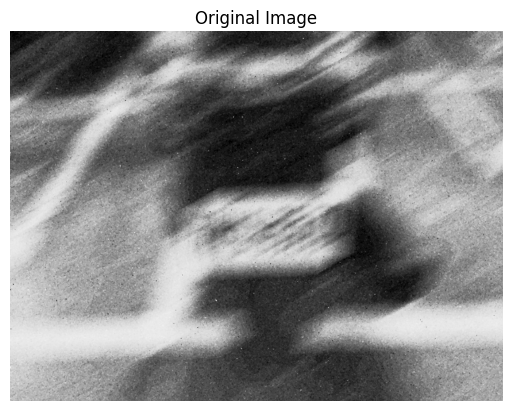

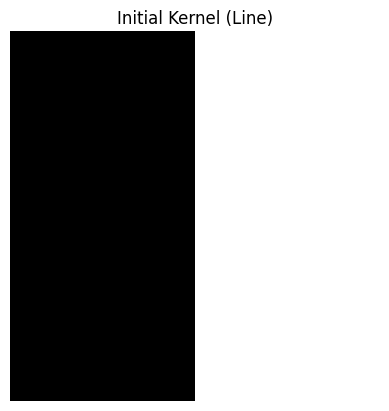

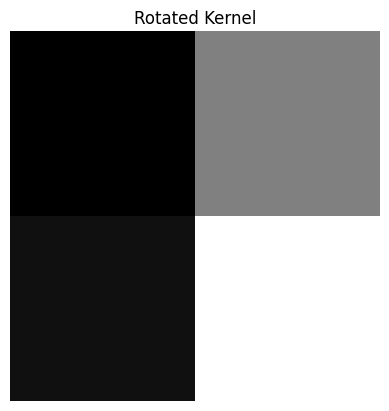

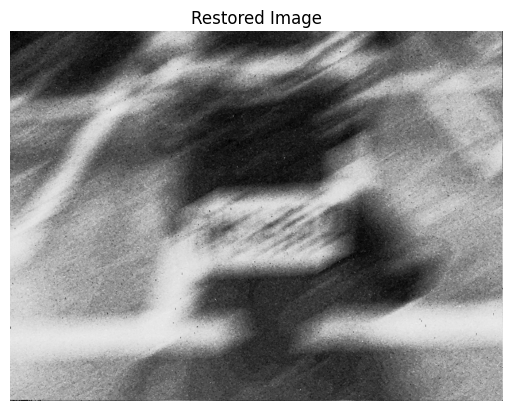

In [90]:
def show_image(title, image):
    """
    顯示影像的輔助函式
    :param title: 影像標題
    :param image: 影像資料
    """
    plt.figure()
    if len(image.shape) == 2:  # 灰階影像
        plt.imshow(image, cmap='gray')
    else:  # 彩色影像
        plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

def motion_blur(image, kernel_size, angle):
    """
    對影像添加運動模糊效果，並顯示每一步驟
    :param image: 原始影像 (彩色或灰階)
    :param kernel_size: 模糊核大小
    :param angle: 模糊方向角度
    :return: 添加模糊後的影像
    """
    # 初始化模糊核
    kernel = np.zeros((kernel_size, kernel_size)) # 開一個全黑畫布
    center = kernel_size // 2 # 計算核的中心位置
    cv2.line(kernel, (center, 0), (center, kernel_size - 1), 1, thickness=1) # 在核中畫一條垂直的直線
    show_image("Initial Kernel (Line)", kernel)

    # 旋轉模糊核
    rotation_matrix = cv2.getRotationMatrix2D((center, center), angle, 1) # 生成旋轉矩陣
    kernel = cv2.warpAffine(kernel, rotation_matrix, (kernel_size, kernel_size)) # 將旋轉矩陣應用到模糊核上
    show_image("Rotated Kernel", kernel)

    # 標準化模糊核
    kernel /= kernel.sum()


    return kernel
def wiener_filter(image, kernel, K=0.01):
    """
    使用維納濾波還原模糊影像，並顯示每一步驟
    :param image: 模糊影像 (彩色或灰階)
    :param kernel: 模糊核
    :param K: 噪聲功率比
    :return: 還原後的影像
    """
    result = np.zeros_like(image)
    if len(image.shape) == 2:  # 灰階影像
        kernel_padded = np.pad(kernel, [(0, image.shape[0] - kernel.shape[0]), 
                                        (0, image.shape[1] - kernel.shape[1])], 
                               mode='constant')

        kernel_fft = np.fft.fft2(kernel_padded)
        image_fft = np.fft.fft2(image)

        kernel_conj = np.conj(kernel_fft)
        wiener_result = (kernel_conj / (np.abs(kernel_fft)**2 + K)) * image_fft
        result = np.abs(np.fft.ifft2(wiener_result))
    else:  # 彩色影像
        for i in range(image.shape[2]):  # 對每個通道處理
            channel = image[:, :, i]
            kernel_padded = np.pad(kernel, [(0, channel.shape[0] - kernel.shape[0]), 
                                            (0, channel.shape[1] - kernel.shape[1])], 
                                   mode='constant')
            kernel_fft = np.fft.fft2(kernel_padded)
            channel_fft = np.fft.fft2(channel)
            kernel_conj = np.conj(kernel_fft)
            wiener_result = (kernel_conj / (np.abs(kernel_fft)**2 + K)) * channel_fft
            result[:, :, i] = np.abs(np.fft.ifft2(wiener_result))
    return result

# 讀取原始影像
image_path = 'wiener_denoised.jpg'  # 替換為你的影像路徑
original_img = cv2.imread(image_path, cv2.IMREAD_COLOR)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  # 將 BGR 轉為 RGB 以便 Matplotlib 顯示

# 顯示原始影像
show_image("Original Image", original_img)

# 模擬動態模糊
kernel_size = 2  # 模糊核大小
angle = 330  # 模糊方向角度
blur_kernel = motion_blur(original_img, kernel_size, angle)

# 還原模糊影像
restored_img = wiener_filter(original_img, blur_kernel, K=0.01)

# 顯示還原影像
show_image("Restored Image", restored_img)
